In [1]:
!pip -q install umap-learn thop


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 76.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's depen

In [2]:
import os, random, time, math, json
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc, precision_recall_fscore_support)
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

import umap
from thop import profile

def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


2025-12-15 19:20:11.596807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765826411.834521      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765826411.945591      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

'cuda'

In [3]:
DATA_ROOT = "/kaggle/input/betel-leaf/Betel Leaf Dataset A Primary Dataset From Field And Controlled Environment/Betel Leaf Dataset/Controlled Environment"  # Kaggle base
# Try to locate jpg/png recursively (you can hardcode exact folder if you know it)
img_paths = glob(os.path.join(DATA_ROOT, "**", "*.jpg"), recursive=True) + \
            glob(os.path.join(DATA_ROOT, "**", "*.jpeg"), recursive=True) + \
            glob(os.path.join(DATA_ROOT, "**", "*.png"), recursive=True)

print("Total images found:", len(img_paths))
print("Example path:", img_paths[0] if len(img_paths)>0 else "None")

# label = parent folder name
labels = [os.path.basename(os.path.dirname(p)) for p in img_paths]

# Filter out weird folders that are not class folders (optional heuristic)
# If your dataset has only 3 folders, this will auto-use them.
label_counts = pd.Series(labels).value_counts()
print("Folder counts:\n", label_counts.head(20))

# Keep top 3 most frequent folders as classes (works even if extra folders exist)
top_classes = label_counts.index[:3].tolist()
keep = [i for i,(p,l) in enumerate(zip(img_paths,labels)) if l in top_classes]

img_paths = [img_paths[i] for i in keep]
labels    = [labels[i] for i in keep]

classes = sorted(list(set(labels)))
class_to_idx = {c:i for i,c in enumerate(classes)}
y = np.array([class_to_idx[l] for l in labels])

print("Classes detected:", classes)
print("Class to idx:", class_to_idx)
print("Final images:", len(img_paths))


Total images found: 893
Example path: /kaggle/input/betel-leaf/Betel Leaf Dataset A Primary Dataset From Field And Controlled Environment/Betel Leaf Dataset/Controlled Environment/Diseased/CE_Diseased_Leaf_007.jpg
Folder counts:
 Dried       340
Healthy     333
Diseased    220
Name: count, dtype: int64
Classes detected: ['Diseased', 'Dried', 'Healthy']
Class to idx: {'Diseased': 0, 'Dried': 1, 'Healthy': 2}
Final images: 893


In [4]:
# 70/15/15 split (stratified)
train_paths, temp_paths, y_train, y_temp = train_test_split(
    img_paths, y, test_size=0.30, random_state=42, stratify=y
)
val_paths, test_paths, y_val, y_test = train_test_split(
    temp_paths, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", len(train_paths), "Val:", len(val_paths), "Test:", len(test_paths))
print("Train class dist:", np.bincount(y_train))
print("Val class dist:", np.bincount(y_val))
print("Test class dist:", np.bincount(y_test))


Train: 625 Val: 134 Test: 134
Train class dist: [154 238 233]
Val class dist: [33 51 50]
Test class dist: [33 51 50]


In [5]:
IMG_SIZE = 224

# BYOL/SimCLR-style augmentations (document this in report)
byol_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


In [6]:
class SSLTwoViewDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        v1 = self.transform(img)
        v2 = self.transform(img)
        return v1, v2

class LabeledDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        x = self.transform(img)
        y = int(self.labels[idx])
        return x, y

BATCH_SSL = 64
BATCH_SUP = 64
NUM_WORKERS = 2

ssl_train_ds = SSLTwoViewDataset(train_paths, byol_transform)
ssl_train_loader = DataLoader(ssl_train_ds, batch_size=BATCH_SSL, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)

sup_train_ds = LabeledDataset(train_paths, y_train, eval_transform)
sup_val_ds   = LabeledDataset(val_paths, y_val, eval_transform)
sup_test_ds  = LabeledDataset(test_paths, y_test, eval_transform)

sup_train_loader = DataLoader(sup_train_ds, batch_size=BATCH_SUP, shuffle=True, num_workers=NUM_WORKERS)
sup_val_loader   = DataLoader(sup_val_ds, batch_size=BATCH_SUP, shuffle=False, num_workers=NUM_WORKERS)
sup_test_loader  = DataLoader(sup_test_ds, batch_size=BATCH_SUP, shuffle=False, num_workers=NUM_WORKERS)


In [7]:
def get_backbone_resnet18():
    m = resnet18(weights=None)  # SSL pretraining from scratch
    # remove fc
    feat_dim = m.fc.in_features
    m.fc = nn.Identity()
    return m, feat_dim

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=1024, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x):
        return self.net(x)

class BYOL(nn.Module):
    def __init__(self, backbone, feat_dim, proj_dim=256, pred_dim=256, m=0.996):
        super().__init__()
        self.m = m

        self.online_backbone = backbone
        self.online_proj = MLP(feat_dim, 1024, proj_dim)
        self.online_pred = MLP(proj_dim, 1024, pred_dim)

        # target network
        self.target_backbone, _ = get_backbone_resnet18()
        self.target_backbone.load_state_dict(self.online_backbone.state_dict())
        self.target_proj = MLP(feat_dim, 1024, proj_dim)
        self.target_proj.load_state_dict(self.online_proj.state_dict())

        for p in self.target_backbone.parameters(): p.requires_grad = False
        for p in self.target_proj.parameters(): p.requires_grad = False

    @torch.no_grad()
    def _ema_update(self):
        for o, t in zip(self.online_backbone.parameters(), self.target_backbone.parameters()):
            t.data = t.data * self.m + o.data * (1 - self.m)
        for o, t in zip(self.online_proj.parameters(), self.target_proj.parameters()):
            t.data = t.data * self.m + o.data * (1 - self.m)

    def forward(self, v1, v2):
        # online
        o1 = self.online_pred(self.online_proj(self.online_backbone(v1)))
        o2 = self.online_pred(self.online_proj(self.online_backbone(v2)))

        with torch.no_grad():
            t1 = self.target_proj(self.target_backbone(v1))
            t2 = self.target_proj(self.target_backbone(v2))

        o1 = F.normalize(o1, dim=-1)
        o2 = F.normalize(o2, dim=-1)
        t1 = F.normalize(t1, dim=-1)
        t2 = F.normalize(t2, dim=-1)
        return o1, o2, t1.detach(), t2.detach()

def byol_loss(p, z):
    # negative cosine similarity
    return 2 - 2 * (p * z).sum(dim=-1).mean()


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

# device
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- helpers ---
def get_backbone_resnet18():
    m = resnet18(weights=None)
    feat_dim = m.fc.in_features
    m.fc = nn.Identity()
    return m, feat_dim

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=1024, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x):
        return self.net(x)

class BYOL(nn.Module):
    def __init__(self, backbone, feat_dim, proj_dim=256, pred_dim=256, m=0.996):
        super().__init__()
        self.m = m

        self.online_backbone = backbone
        self.online_proj = MLP(feat_dim, 1024, proj_dim)
        self.online_pred = MLP(proj_dim, 1024, pred_dim)

        self.target_backbone, _ = get_backbone_resnet18()
        self.target_backbone.load_state_dict(self.online_backbone.state_dict())
        self.target_proj = MLP(feat_dim, 1024, proj_dim)
        self.target_proj.load_state_dict(self.online_proj.state_dict())

        for p in self.target_backbone.parameters(): p.requires_grad = False
        for p in self.target_proj.parameters(): p.requires_grad = False

    @torch.no_grad()
    def _ema_update(self):
        for o, t in zip(self.online_backbone.parameters(), self.target_backbone.parameters()):
            t.data = t.data * self.m + o.data * (1 - self.m)
        for o, t in zip(self.online_proj.parameters(), self.target_proj.parameters()):
            t.data = t.data * self.m + o.data * (1 - self.m)

    def forward(self, v1, v2):
        o1 = self.online_pred(self.online_proj(self.online_backbone(v1)))
        o2 = self.online_pred(self.online_proj(self.online_backbone(v2)))

        with torch.no_grad():
            t1 = self.target_proj(self.target_backbone(v1))
            t2 = self.target_proj(self.target_backbone(v2))

        o1 = F.normalize(o1, dim=-1)
        o2 = F.normalize(o2, dim=-1)
        t1 = F.normalize(t1, dim=-1)
        t2 = F.normalize(t2, dim=-1)
        return o1, o2, t1.detach(), t2.detach()

def byol_loss(p, z):
    return 2 - 2 * (p * z).sum(dim=-1).mean()

# --- build model + optimizer ONLY if not already defined ---
if "model" not in globals():
    backbone, feat_dim = get_backbone_resnet18()
    model = BYOL(backbone, feat_dim, proj_dim=256, pred_dim=256, m=0.996).to(device)
    print("✅ BYOL model created")

if "opt" not in globals():
    opt = torch.optim.AdamW(
        list(model.online_backbone.parameters()) +
        list(model.online_proj.parameters()) +
        list(model.online_pred.parameters()),
        lr=3e-4, weight_decay=1e-4
    )
    print("✅ Optimizer created")

print("Ready -> device:", device)


✅ BYOL model created
✅ Optimizer created
Ready -> device: cuda


/tmp/ipykernel_47/251765422.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_47/251765422.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # 🔥 fast


SSL Epoch 001/100 | loss = 2.3982
SSL Epoch 002/100 | loss = 1.6144
SSL Epoch 003/100 | loss = 1.5360
SSL Epoch 004/100 | loss = 1.4800
SSL Epoch 005/100 | loss = 1.4366
SSL Epoch 006/100 | loss = 1.4041
SSL Epoch 007/100 | loss = 1.3958
SSL Epoch 008/100 | loss = 1.3196
SSL Epoch 009/100 | loss = 1.2718
SSL Epoch 010/100 | loss = 1.2568
SSL Epoch 011/100 | loss = 1.1497
SSL Epoch 012/100 | loss = 1.1603
SSL Epoch 013/100 | loss = 1.1771
SSL Epoch 014/100 | loss = 1.1145
SSL Epoch 015/100 | loss = 1.1210
SSL Epoch 016/100 | loss = 1.1000
SSL Epoch 017/100 | loss = 1.0325
SSL Epoch 018/100 | loss = 0.9301
SSL Epoch 019/100 | loss = 0.9449
SSL Epoch 020/100 | loss = 0.9252
SSL Epoch 021/100 | loss = 0.8945
SSL Epoch 022/100 | loss = 0.8261
SSL Epoch 023/100 | loss = 0.8156
SSL Epoch 024/100 | loss = 0.7373
SSL Epoch 025/100 | loss = 0.7271
SSL Epoch 026/100 | loss = 0.8177
SSL Epoch 027/100 | loss = 0.6823
SSL Epoch 028/100 | loss = 0.7111
SSL Epoch 029/100 | loss = 0.5913
SSL Epoch 030/

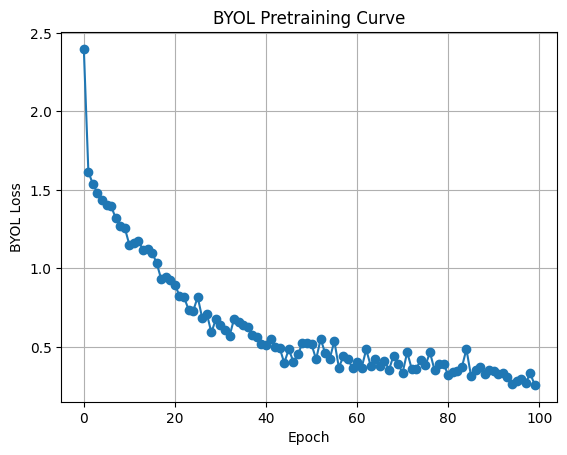

In [9]:
from torch.cuda.amp import autocast, GradScaler

EPOCHS_SSL = 100         # assignment demo এর জন্য enough
scaler = GradScaler()

ssl_losses = []
start_time = time.time()

for epoch in range(1, EPOCHS_SSL + 1):
    model.train()
    epoch_loss = 0.0

    for v1, v2 in ssl_train_loader:
        v1 = v1.to(device, non_blocking=True)
        v2 = v2.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)

        with autocast():   # 🔥 fast
            o1, o2, t1, t2 = model(v1, v2)
            loss = byol_loss(o1, t2) + byol_loss(o2, t1)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        model._ema_update()
        epoch_loss += loss.item()

    epoch_loss /= len(ssl_train_loader)
    ssl_losses.append(epoch_loss)

    # ✅ EVERY epoch print (NO indentation issue)
    print(f"SSL Epoch {epoch:03d}/{EPOCHS_SSL} | loss = {epoch_loss:.4f}")

ssl_train_time = time.time() - start_time
print(f"\nTotal SSL Pretraining Time: {ssl_train_time:.2f} sec")

# learning curve
plt.figure()
plt.plot(ssl_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("BYOL Loss")
plt.title("BYOL Pretraining Curve")
plt.grid(True)
plt.show()


In [10]:
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.online_backbone.state_dict(), "checkpoints/byol_resnet18_encoder.pth")
print("Saved frozen encoder:", "checkpoints/byol_resnet18_encoder.pth")


Saved frozen encoder: checkpoints/byol_resnet18_encoder.pth


In [24]:
# ===== Cell 11: Extract features from frozen encoder =====
from torchvision.models import resnet18

def get_backbone_resnet18():
    m = resnet18(weights=None)
    feat_dim = m.fc.in_features
    m.fc = nn.Identity()
    return m, feat_dim

# Load frozen encoder
enc, feat_dim = get_backbone_resnet18()
enc.load_state_dict(torch.load("checkpoints/byol_resnet18_encoder.pth", map_location="cpu"))
enc = enc.to(device).eval()

for p in enc.parameters():
    p.requires_grad = False

@torch.no_grad()
def extract_features(loader):
    feats, labels = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        f = enc(x).detach().cpu().numpy()
        feats.append(f)
        labels.append(y.numpy())
    return np.concatenate(feats, 0), np.concatenate(labels, 0)

Xtr, ytr = extract_features(sup_train_loader)
Xva, yva = extract_features(sup_val_loader)
Xte, yte = extract_features(sup_test_loader)

print("Xtr:", Xtr.shape, "Xva:", Xva.shape, "Xte:", Xte.shape)


Xtr: (625, 512) Xva: (134, 512) Xte: (134, 512)


LP Epoch 01/50 | loss=1.3572 | val_acc=0.1791
LP Epoch 02/50 | loss=1.1372 | val_acc=0.3806
LP Epoch 03/50 | loss=1.0193 | val_acc=0.3806
LP Epoch 04/50 | loss=0.9488 | val_acc=0.3881
LP Epoch 05/50 | loss=0.8864 | val_acc=0.4701
LP Epoch 06/50 | loss=0.8243 | val_acc=0.5522
LP Epoch 07/50 | loss=0.7656 | val_acc=0.6866
LP Epoch 08/50 | loss=0.7138 | val_acc=0.7239
LP Epoch 09/50 | loss=0.6693 | val_acc=0.7537
LP Epoch 10/50 | loss=0.6313 | val_acc=0.7388
LP Epoch 11/50 | loss=0.6002 | val_acc=0.7537
LP Epoch 12/50 | loss=0.5766 | val_acc=0.7537
LP Epoch 13/50 | loss=0.5598 | val_acc=0.7388
LP Epoch 14/50 | loss=0.5478 | val_acc=0.7388
LP Epoch 15/50 | loss=0.5374 | val_acc=0.7388
LP Epoch 16/50 | loss=0.5268 | val_acc=0.7463
LP Epoch 17/50 | loss=0.5155 | val_acc=0.7463
LP Epoch 18/50 | loss=0.5042 | val_acc=0.7537
LP Epoch 19/50 | loss=0.4942 | val_acc=0.7313
LP Epoch 20/50 | loss=0.4858 | val_acc=0.7537
LP Epoch 21/50 | loss=0.4791 | val_acc=0.7612
LP Epoch 22/50 | loss=0.4734 | val

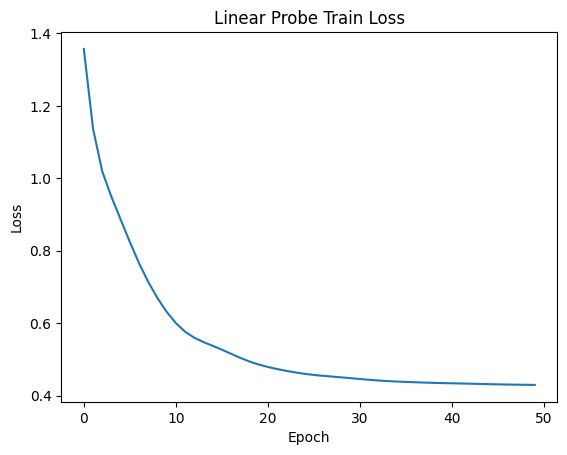

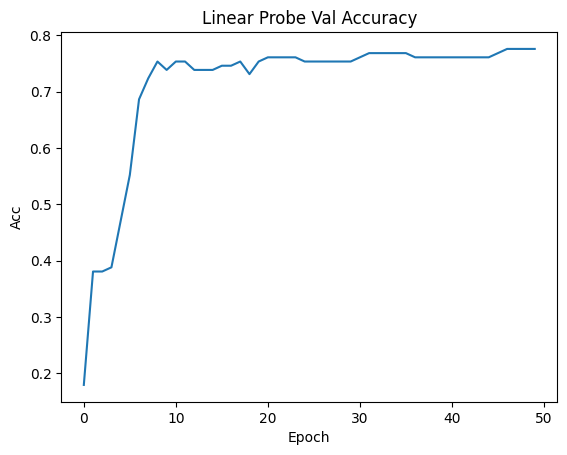

Linear Probe TEST acc: 0.7910447761194029


In [25]:
# ===== Cell 12: Linear Probe on frozen features =====
from sklearn.metrics import accuracy_score

num_classes = len(classes)

class LinearHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

lin = LinearHead(Xtr.shape[1], num_classes).to(device)
opt_lp = torch.optim.AdamW(lin.parameters(), lr=1e-3, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

EPOCHS_LP = 50
lp_train_loss = []
lp_val_acc = []

start = time.time()
for ep in range(1, EPOCHS_LP + 1):
    lin.train()

    Xb = torch.tensor(Xtr, dtype=torch.float32, device=device)
    yb = torch.tensor(ytr, dtype=torch.long, device=device)

    opt_lp.zero_grad(set_to_none=True)
    logits = lin(Xb)
    loss = crit(logits, yb)
    loss.backward()
    opt_lp.step()

    lin.eval()
    with torch.no_grad():
        v_logits = lin(torch.tensor(Xva, dtype=torch.float32, device=device)).cpu().numpy()
        v_pred = v_logits.argmax(1)
        v_acc = accuracy_score(yva, v_pred)

    lp_train_loss.append(loss.item())
    lp_val_acc.append(v_acc)

    print(f"LP Epoch {ep:02d}/{EPOCHS_LP} | loss={loss.item():.4f} | val_acc={v_acc:.4f}")

lp_time = time.time() - start
print("✅ Linear Probe train time (sec):", lp_time)

plt.figure(); plt.plot(lp_train_loss); plt.title("Linear Probe Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.show()
plt.figure(); plt.plot(lp_val_acc); plt.title("Linear Probe Val Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.show()

# final LP test prediction
lin.eval()
with torch.no_grad():
    te_logits = lin(torch.tensor(Xte, dtype=torch.float32, device=device)).cpu().numpy()
lp_pred = te_logits.argmax(1)
print("Linear Probe TEST acc:", accuracy_score(yte, lp_pred))


In [26]:
def eval_sklearn(model, X_train, y_train, X_test, y_test, name="model"):
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    t1 = time.time()
    pred = model.predict(X_test)
    test_time = time.time() - t1

    acc = accuracy_score(y_test, pred)
    print(f"\n[{name}] acc={acc:.4f} | train_time={train_time:.2f}s | test_time={test_time:.2f}s")
    print(classification_report(y_test, pred, target_names=classes))
    return acc, train_time, test_time, pred

results = {}

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=300, random_state=42)
results["MLP"] = eval_sklearn(mlp, Xtr, ytr, Xte, yte, "MLP")

# SVM (RBF)
svm = SVC(kernel="rbf", probability=True, random_state=42)
results["SVM"] = eval_sklearn(svm, Xtr, ytr, Xte, yte, "SVM")

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
results["DT"] = eval_sklearn(dt, Xtr, ytr, Xte, yte, "DecisionTree")

# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
results["RF"] = eval_sklearn(rf, Xtr, ytr, Xte, yte, "RandomForest")



[MLP] acc=0.8060 | train_time=0.68s | test_time=0.00s
              precision    recall  f1-score   support

    Diseased       0.61      0.61      0.61        33
       Dried       0.98      0.96      0.97        51
     Healthy       0.76      0.78      0.77        50

    accuracy                           0.81       134
   macro avg       0.78      0.78      0.78       134
weighted avg       0.81      0.81      0.81       134


[SVM] acc=0.7612 | train_time=0.15s | test_time=0.01s
              precision    recall  f1-score   support

    Diseased       0.57      0.24      0.34        33
       Dried       0.98      0.96      0.97        51
     Healthy       0.64      0.90      0.75        50

    accuracy                           0.76       134
   macro avg       0.73      0.70      0.69       134
weighted avg       0.75      0.76      0.73       134


[DecisionTree] acc=0.8060 | train_time=0.26s | test_time=0.00s
              precision    recall  f1-score   support

    Disea

FT Epoch 01/50 | loss=0.6131 | train_acc=0.7632 | val_acc=0.6940
FT Epoch 02/50 | loss=0.3060 | train_acc=0.8912 | val_acc=0.8731
FT Epoch 03/50 | loss=0.3112 | train_acc=0.8848 | val_acc=0.7836
FT Epoch 04/50 | loss=0.1907 | train_acc=0.9328 | val_acc=0.9179
FT Epoch 05/50 | loss=0.1643 | train_acc=0.9424 | val_acc=0.8731
FT Epoch 06/50 | loss=0.1093 | train_acc=0.9632 | val_acc=0.7015
FT Epoch 07/50 | loss=0.1095 | train_acc=0.9632 | val_acc=0.8881
FT Epoch 08/50 | loss=0.1159 | train_acc=0.9584 | val_acc=0.9328
FT Epoch 09/50 | loss=0.0829 | train_acc=0.9744 | val_acc=0.9552
FT Epoch 10/50 | loss=0.0601 | train_acc=0.9808 | val_acc=0.9552
FT Epoch 11/50 | loss=0.0687 | train_acc=0.9808 | val_acc=0.7239
FT Epoch 12/50 | loss=0.0478 | train_acc=0.9824 | val_acc=0.9254
FT Epoch 13/50 | loss=0.0360 | train_acc=0.9888 | val_acc=0.9254
FT Epoch 14/50 | loss=0.0387 | train_acc=0.9872 | val_acc=0.9328
FT Epoch 15/50 | loss=0.0160 | train_acc=0.9936 | val_acc=0.8955
FT Epoch 16/50 | loss=0.0

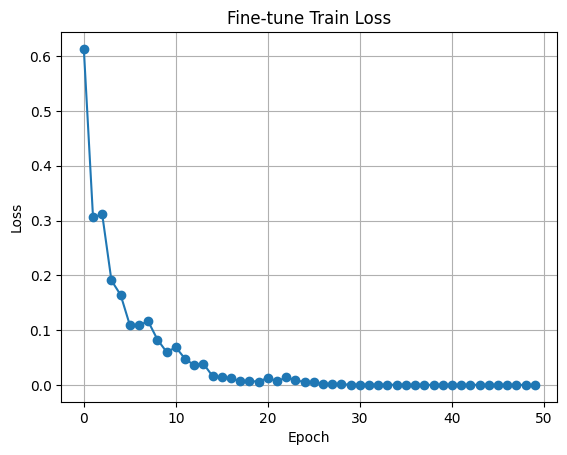

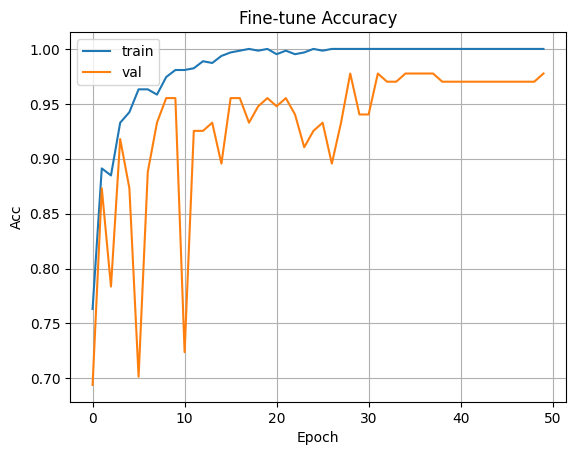

✅ Fine-tune TEST acc: 0.9776119402985075


In [27]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score

scaler = GradScaler("cuda") if device == "cuda" else GradScaler()

# Rebuild model (encoder + head) from saved BYOL encoder
ft_backbone, feat_dim = get_backbone_resnet18()
ft_backbone.load_state_dict(torch.load("checkpoints/byol_resnet18_encoder.pth", map_location="cpu"))

ft_model = nn.Sequential(
    ft_backbone,
    nn.Linear(feat_dim, len(classes))
).to(device)

opt_ft = torch.optim.AdamW(ft_model.parameters(), lr=3e-4, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

def train_one_epoch(model, loader):
    model.train()
    losses, preds, gts = [], [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        opt_ft.zero_grad(set_to_none=True)

        with autocast(device_type="cuda" if device=="cuda" else "cpu"):
            logits = model(x)
            loss = crit(logits, y)

        scaler.scale(loss).backward()
        scaler.step(opt_ft)
        scaler.update()

        losses.append(loss.item())
        preds.append(logits.argmax(1).detach().cpu().numpy())
        gts.append(y.detach().cpu().numpy())

    return float(np.mean(losses)), accuracy_score(np.concatenate(gts), np.concatenate(preds))

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    preds, gts = [], []
    probs = []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        p = torch.softmax(logits, dim=1).cpu().numpy()
        probs.append(p)
        preds.append(p.argmax(1))
        gts.append(y.numpy())
    return np.concatenate(preds), np.concatenate(gts), np.concatenate(probs)

EPOCHS_FT = 50
ft_loss_curve, ft_train_acc_curve, ft_val_acc_curve = [], [], []

ft_start = time.time()
for ep in range(1, EPOCHS_FT + 1):
    loss, tr_acc = train_one_epoch(ft_model, sup_train_loader)
    va_pred, va_gt, _ = eval_one_epoch(ft_model, sup_val_loader)
    va_acc = accuracy_score(va_gt, va_pred)

    ft_loss_curve.append(loss)
    ft_train_acc_curve.append(tr_acc)
    ft_val_acc_curve.append(va_acc)

    # ✅ print EVERY epoch
    print(f"FT Epoch {ep:02d}/{EPOCHS_FT} | loss={loss:.4f} | train_acc={tr_acc:.4f} | val_acc={va_acc:.4f}")

ft_train_time = time.time() - ft_start
print(f"\n✅ Fine-tune train time (sec): {ft_train_time:.2f}")

plt.figure(); plt.plot(ft_loss_curve, marker="o"); plt.title("Fine-tune Train Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.show()
plt.figure(); plt.plot(ft_train_acc_curve, label="train"); plt.plot(ft_val_acc_curve, label="val"); plt.legend(); plt.title("Fine-tune Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.grid(True); plt.show()

ft_pred, ft_gt, ft_probs = eval_one_epoch(ft_model, sup_test_loader)
ft_test_acc = accuracy_score(ft_gt, ft_pred)
print("✅ Fine-tune TEST acc:", ft_test_acc)


Per-class accuracy: {'Diseased': 0.9696969696969697, 'Dried': 1.0, 'Healthy': 0.96}

Classification report:
               precision    recall  f1-score   support

    Diseased       0.94      0.97      0.96        33
       Dried       1.00      1.00      1.00        51
     Healthy       0.98      0.96      0.97        50

    accuracy                           0.98       134
   macro avg       0.97      0.98      0.97       134
weighted avg       0.98      0.98      0.98       134



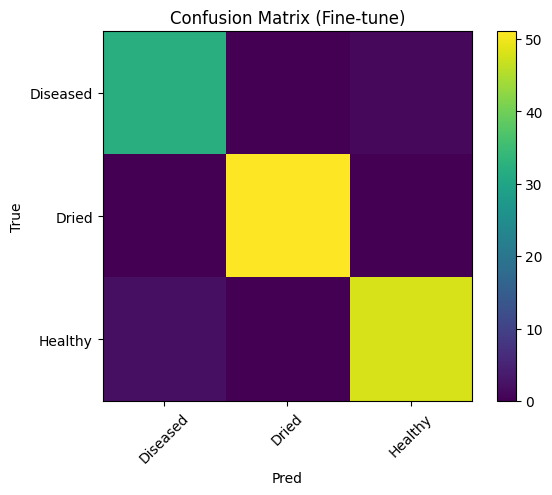

Macro ROC-AUC (OVR): 0.998006229194348


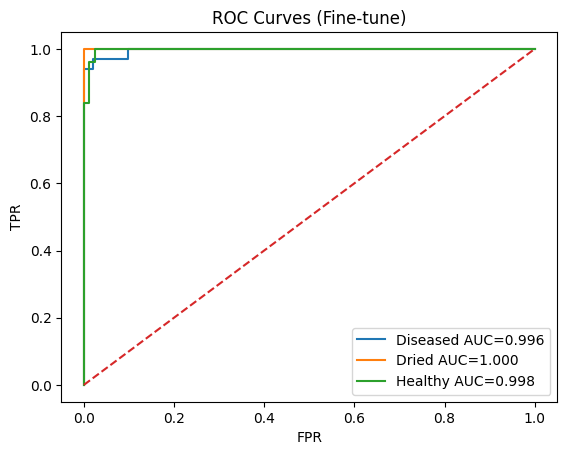

In [28]:
def per_class_accuracy(y_true, y_pred, n_cls):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_cls)))
    with np.errstate(divide='ignore', invalid='ignore'):
        pacc = np.diag(cm) / cm.sum(axis=1)
    return cm, np.nan_to_num(pacc)

@torch.no_grad()
def predict_proba_pytorch(model, loader, is_sequential=True):
    model.eval()
    probs, gts = [], []
    for x,y in loader:
        x = x.to(device)
        logits = model(x) if is_sequential else model(x)
        p = torch.softmax(logits, dim=1).cpu().numpy()
        probs.append(p)
        gts.append(y.numpy())
    return np.concatenate(probs), np.concatenate(gts)

# Fine-tune ROC-AUC
ft_probs, ft_ytrue = predict_proba_pytorch(ft_model, sup_test_loader, is_sequential=True)
ft_ypred = ft_probs.argmax(1)

cm, pacc = per_class_accuracy(ft_ytrue, ft_ypred, len(classes))
print("Per-class accuracy:", {classes[i]: float(pacc[i]) for i in range(len(classes))})
print("\nClassification report:\n", classification_report(ft_ytrue, ft_ypred, target_names=classes))

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Fine-tune)")
plt.xlabel("Pred"); plt.ylabel("True")
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
plt.colorbar()
plt.show()

# ROC-AUC (multiclass OVR)
y_bin = label_binarize(ft_ytrue, classes=list(range(len(classes))))
roc_auc = roc_auc_score(y_bin, ft_probs, average="macro", multi_class="ovr")
print("Macro ROC-AUC (OVR):", roc_auc)

plt.figure()
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:,i], ft_probs[:,i])
    plt.plot(fpr, tpr, label=f"{c} AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves (Fine-tune)")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend()
plt.show()


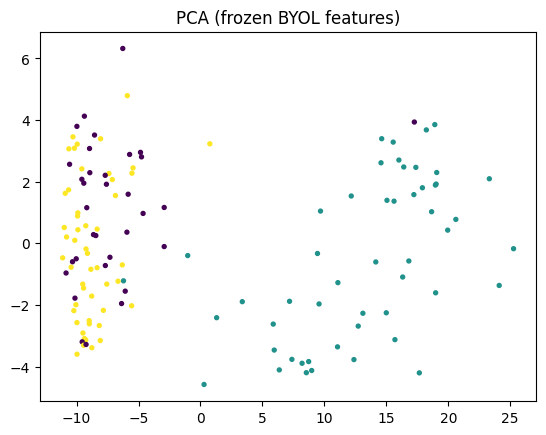

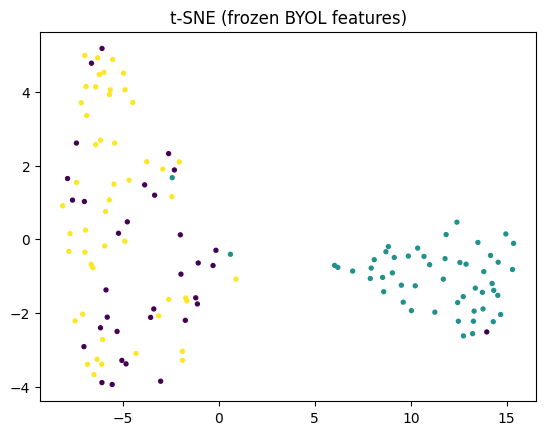

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


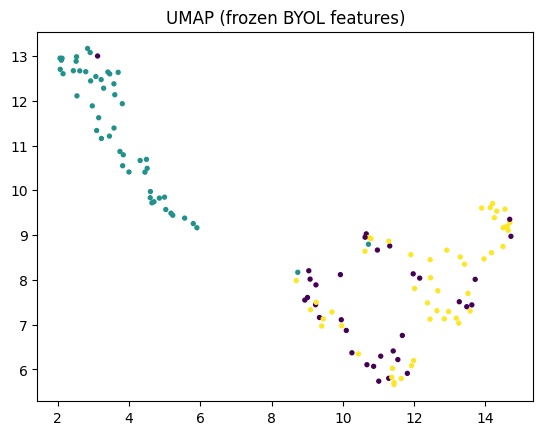

Silhouette score (feature space): 0.2471132129430771


In [29]:
X = Xte
Y = yte

# PCA
pca2 = PCA(n_components=2, random_state=42).fit_transform(X)
plt.figure()
plt.scatter(pca2[:,0], pca2[:,1], c=Y, s=8)
plt.title("PCA (frozen BYOL features)")
plt.show()

# t-SNE (can be slow)
tsne2 = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42).fit_transform(X)
plt.figure()
plt.scatter(tsne2[:,0], tsne2[:,1], c=Y, s=8)
plt.title("t-SNE (frozen BYOL features)")
plt.show()

# UMAP
umap2 = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
plt.figure()
plt.scatter(umap2[:,0], umap2[:,1], c=Y, s=8)
plt.title("UMAP (frozen BYOL features)")
plt.show()

sil = silhouette_score(X, Y, metric="euclidean")
print("Silhouette score (feature space):", sil)


In [31]:
for k in [1,5,20]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtr, ytr)
    pred = knn.predict(Xte)
    acc = accuracy_score(yte, pred)
    print(f"kNN (k={k}) acc:", acc)


kNN (k=1) acc: 0.8059701492537313
kNN (k=5) acc: 0.7985074626865671
kNN (k=20) acc: 0.7985074626865671


Label fraction 1% -> acc=0.7761
Label fraction 5% -> acc=0.7910
Label fraction 10% -> acc=0.7910
Label fraction 25% -> acc=0.8284
Label fraction 50% -> acc=0.8358


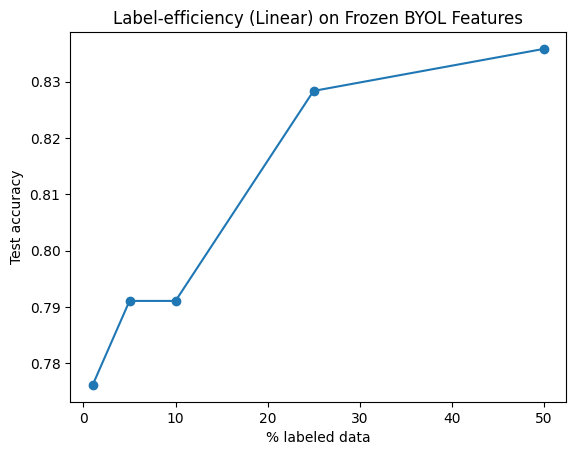

In [32]:
fractions = [0.01, 0.05, 0.10, 0.25, 0.50]
eff = []

for frac in fractions:
    # stratified subset from train
    X_sub, _, y_sub, _ = train_test_split(Xtr, ytr, train_size=frac, random_state=42, stratify=ytr)

    # simple sklearn logistic-like linear classifier: use MLP with no hidden as linear
    # (or you can re-run torch linear head quickly)
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_sub, y_sub)
    pred = clf.predict(Xte)
    acc = accuracy_score(yte, pred)
    eff.append(acc)
    print(f"Label fraction {int(frac*100)}% -> acc={acc:.4f}")

plt.figure()
plt.plot([f*100 for f in fractions], eff, marker="o")
plt.title("Label-efficiency (Linear) on Frozen BYOL Features")
plt.xlabel("% labeled data")
plt.ylabel("Test accuracy")
plt.show()


In [34]:
# GFLOPs for encoder (same input size 224)
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
enc_for_gflops, _ = get_backbone_resnet18()
enc_for_gflops.load_state_dict(torch.load("checkpoints/byol_resnet18_encoder.pth", map_location="cpu"))
enc_for_gflops = enc_for_gflops.to(device).eval()

macs, params = profile(enc_for_gflops, inputs=(dummy,), verbose=False)
gflops = (2*macs) / 1e9  # approximate FLOPs = 2*MACs
print("Encoder Params (M):", params/1e6)
print("Encoder GFLOPs (@224):", gflops)

# inference time on test loader
@torch.no_grad()
def measure_infer_time(model, loader, n_warmup=5, n_batches=20):
    model.eval()
    total_batches = len(loader)
    if total_batches == 0:
        raise ValueError("Test loader is empty (0 batches). Check dataset split / paths.")

    # auto-adjust so we never exceed available batches
    n_warmup = min(n_warmup, total_batches)
    n_batches = min(n_batches, max(1, total_batches - n_warmup))

    it = iter(loader)
    for _ in range(n_warmup):
        x, y = next(it)
        x = x.to(device, non_blocking=True)
        _ = model(x)

    t0 = time.time()
    for _ in range(n_batches):
        x, y = next(it)
        x = x.to(device, non_blocking=True)
        _ = model(x)

    return (time.time() - t0) / n_batches

print("Test loader batches:", len(sup_test_loader))
avg_batch_time = measure_infer_time(ft_model, sup_test_loader, n_warmup=5, n_batches=20)
print("Avg inference time per batch (sec):", avg_batch_time)


Encoder Params (M): 11.176512
Encoder GFLOPs (@224): 3.647043584
Test loader batches: 3


StopIteration: 

In [38]:
import os

path = "/kaggle/working/checkpoints/byol_resnet18_encoder.pth"

print("Exists:", os.path.exists(path))
print("Size (MB):", os.path.getsize(path)/1024/1024 if os.path.exists(path) else "N/A")
print("Absolute path:", os.path.abspath(path))


Exists: True
Size (MB): 42.711313247680664
Absolute path: /kaggle/working/checkpoints/byol_resnet18_encoder.pth


In [41]:
import os, glob

# Kaggle working output folder
ckpt_dir = "/kaggle/working/checkpoints"

print("Checkpoint dir exists?", os.path.exists(ckpt_dir))
print("\nFiles in checkpoints:")
for f in os.listdir(ckpt_dir):
    print(" -", f)

# find any .pth file
pth_files = glob.glob(os.path.join(ckpt_dir, "*.pth"))
print("\nPTH files found:", pth_files)

# pick encoder automatically (you can also manually choose)
encoder_candidates = [p for p in pth_files if "encoder" in os.path.basename(p).lower()]
ENCODER_PATH = encoder_candidates[0] if len(encoder_candidates) else (pth_files[0] if len(pth_files) else None)

print("\n✅ ENCODER_PATH =", ENCODER_PATH)
if ENCODER_PATH:
    print("Exists:", os.path.exists(ENCODER_PATH))
    print("Size (MB):", os.path.getsize(ENCODER_PATH)/1024/1024)


Checkpoint dir exists? True

Files in checkpoints:
 - byol_resnet18_encoder.pth

PTH files found: ['/kaggle/working/checkpoints/byol_resnet18_encoder.pth']

✅ ENCODER_PATH = /kaggle/working/checkpoints/byol_resnet18_encoder.pth
Exists: True
Size (MB): 42.711313247680664


In [42]:
import os, torch

ENCODER_PATH = "/kaggle/working/checkpoints/byol_resnet18_encoder.pth"
os.makedirs(os.path.dirname(ENCODER_PATH), exist_ok=True)

torch.save(model.online_backbone.state_dict(), ENCODER_PATH)

print("✅ Saved encoder at:", ENCODER_PATH)
print("Exists:", os.path.exists(ENCODER_PATH))
print("Size (MB):", os.path.getsize(ENCODER_PATH)/1024/1024)


✅ Saved encoder at: /kaggle/working/checkpoints/byol_resnet18_encoder.pth
Exists: True
Size (MB): 42.711313247680664


In [43]:
summary = {
  "encoder_path": ENCODER_PATH
}
print(summary)


{'encoder_path': '/kaggle/working/checkpoints/byol_resnet18_encoder.pth'}


In [44]:
from torchvision.models import resnet18
import torch.nn as nn
import torch

def get_backbone_resnet18():
    m = resnet18(weights=None)
    feat_dim = m.fc.in_features
    m.fc = nn.Identity()
    return m, feat_dim

enc, _ = get_backbone_resnet18()
enc.load_state_dict(torch.load(
    "/kaggle/working/checkpoints/byol_resnet18_encoder.pth",
    map_location="cpu"
))
enc.eval()
print("✅ Encoder loaded successfully")


✅ Encoder loaded successfully


In [45]:
import shutil
import os

ENCODER_PATH = "/kaggle/working/checkpoints/byol_resnet18_encoder.pth"
ZIP_PATH = "/kaggle/working/byol_encoder.zip"

assert os.path.exists(ENCODER_PATH), "❌ Encoder file not found!"

shutil.make_archive(
    base_name="/kaggle/working/byol_encoder",
    format="zip",
    root_dir="/kaggle/working/checkpoints"
)

print("✅ ZIP created at:", ZIP_PATH)
print("ZIP exists?", os.path.exists(ZIP_PATH))
print("ZIP size (MB):", os.path.getsize(ZIP_PATH)/1024/1024)


✅ ZIP created at: /kaggle/working/byol_encoder.zip
ZIP exists? True
ZIP size (MB): 39.626190185546875
